In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [14]:
rho= 1
mu= 1
nu=mu/rho
D= 0.039
L= 0.42
u_in=1

In [15]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((2,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 3)
])

NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                96        
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,307
Trainable params: 2,307
Non-trainable params: 0
_________________________________________________________________


In [16]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)


In [17]:
def pde_loss(x, y, net, nu, rho, D, L, u_in):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 
    
    # Compute derivatives
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)
        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)
            u = net(tf.concat([x, y], axis=1))[:,0]
        u_x, u_y = g.gradient(u, [x, y])
    u_xx = g.gradient(u_x, x)
    u_yy = g.gradient(u_y, y)
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)
        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)
            v = net(tf.concat([x, y], axis=1))[:,1]
        v_x, v_y = g.gradient(v, [x, y])
    v_xx = g.gradient(v_x, x)
    v_yy = g.gradient(v_y, y)
    with tf.GradientTape() as g:
        g.watch(x)
        g.watch(y)           
        p = net(tf.concat([x, y], axis=1))[:,2]
        p_x, p_y = g.gradient(p, [x, y])
        
    bc_u_1 =  net(tf.concat([x, tf.fill(tf.shape(y), -D/2)], axis=1))[:,0]
    bc_v_1 =  net(tf.concat([x, tf.fill(tf.shape(y), -D/2)], axis=1))[:,1]
    bc_u_2 =  net(tf.concat([x, tf.fill(tf.shape(y), D/2)], axis=1))[:,0]
    bc_v_2 =  net(tf.concat([x, tf.fill(tf.shape(y), D/2)], axis=1))[:,1]

    bc_inlet_u = net(tf.concat([tf.fill(tf.shape(x), -L/2), y], axis=1))[:,0] -u_in
    bc_inlet_v = net(tf.concat([tf.fill(tf.shape(x), -L/2), y], axis=1))[:,1]

    bc_outlet_p = net(tf.concat([tf.fill(tf.shape(x), L/2), y], axis=1))[:,2]

    # Compute PDE terms
    pde_u = u * u_x + v * u_y + 1/rho * p_x - nu * (u_xx + u_yy )
    pde_v = u * v_x + v * v_y + 1/rho * p_y - nu * (v_xx + v_yy )
    pde_0 = u_x+ v_y
    

    # Compute square loss
    #square_loss = tf.square(pde_u) + tf.square(pde_v) + tf.square(pde_0)+tf.square(bc_u_1)+tf.square(bc_v_1)+tf.square(bc_u_2)+tf.square(bc_v_2)+tf.square(bc_inlet_u)+tf.square(bc_inlet_v)+tf.square(bc_outlet_p)
    square_loss = tf.square(pde_u) + tf.square(pde_v) + tf.square(pde_0)+tf.square(bc_u_1)+tf.square(bc_v_1)+tf.square(bc_u_2)+tf.square(bc_v_2)+tf.square(bc_inlet_u)+tf.square(bc_inlet_v)+tf.square(bc_outlet_p)

    total_loss = tf.reduce_mean(square_loss)

    return total_loss




In [18]:
def generate_points_pde(L, D, N_pde):
    points = []
    while len(points) < N_pde:
        x = random.uniform(-L/2, L/2)
        y = random.uniform(-D/2, D/2)
        points.append((x, y))
    return np.array(points)


In [19]:
N_pde = 500
train_pde = generate_points_pde(L, D, N_pde)
train_x_pde=train_pde[:,0]
train_y_pde=train_pde[:,1]


NameError: name 'train_x_in' is not defined

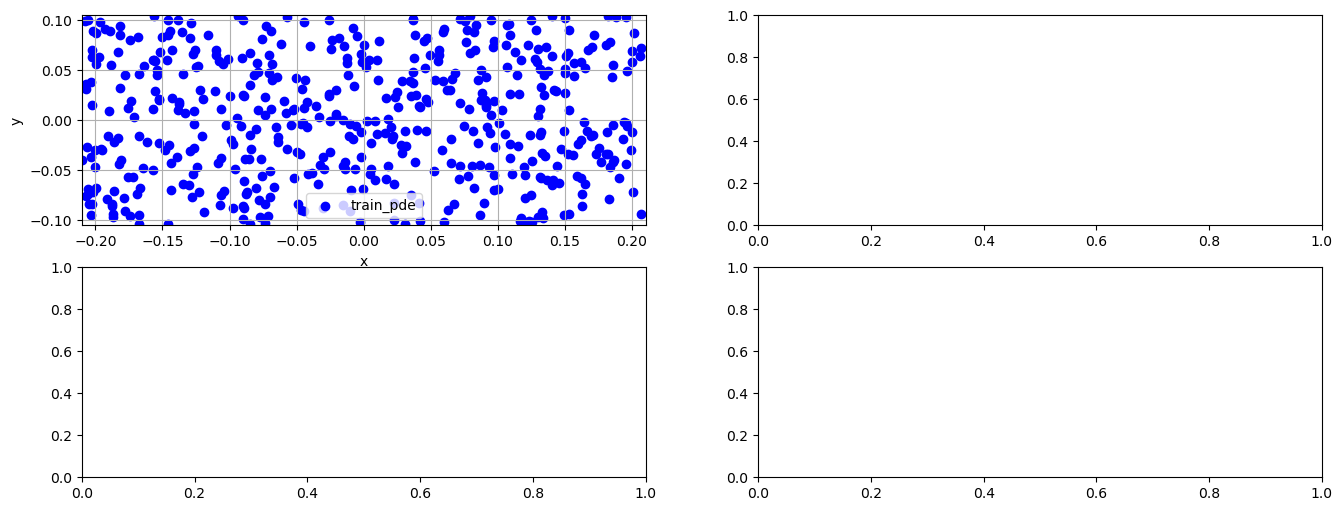

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))


axs[0,0].scatter(train_x_pde, train_y_pde, color='b', marker='o', label='train_pde')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0,0].set_xlim([-L/2, L/2])  
axs[0,0].set_ylim([-D/2, D/2]) 
axs[0,0].grid(True)
axs[0,0].legend()


axs[0,1].scatter(train_x_in, train_y_in, color='b', marker='o', label='train_in')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')
axs[0,1].set_xlim([-L/2, L/2])  
axs[0,1].set_ylim([-D/2, D/2]) 
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].scatter(train_x_out, train_y_out, color='b', marker='o', label='train_out')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1,0].set_xlim([-L/2, L/2])  
axs[1,0].set_ylim([-D/2, D/2]) 
axs[1,0].grid(True)
axs[1,0].legend()


axs[1,1].scatter(train_x_BC, train_y_BC, color='b', marker='o', label='train_BC')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1,1].set_xlim([-L/2, L/2])  
axs[1,1].set_ylim([-D/2, D/2]) 
axs[1,1].grid(True)
axs[1,1].legend()


plt.show()

2.5156472
0.23933497


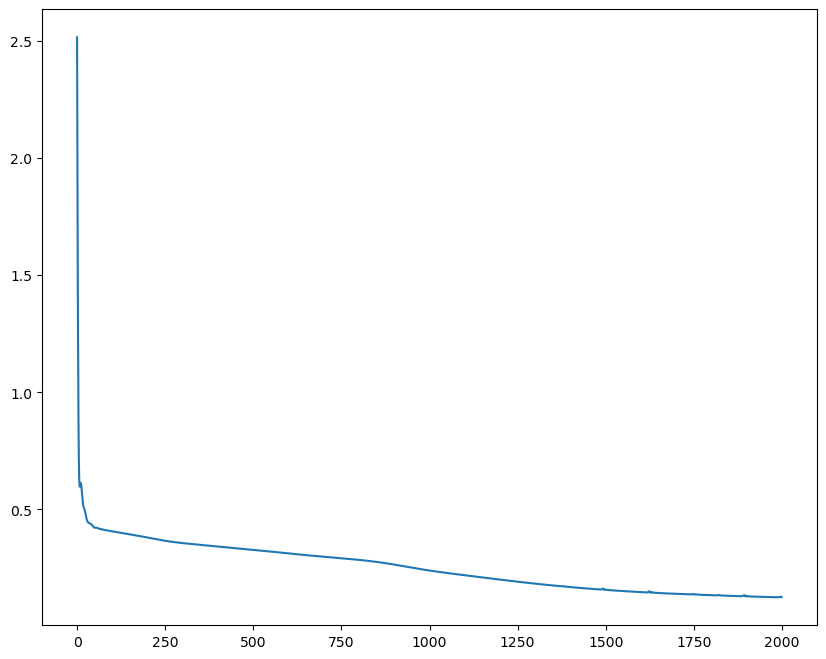

In [10]:
train_loss_record = []

for itr in range(2000):
    with tf.GradientTape() as tape:
        
        
        total_loss = pde_loss(train_x_pde, train_y_pde, NN, nu, rho, D, L, u_in)
        
        train_loss_record.append(total_loss)
                
        grad_w = tape.gradient(total_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))
    
    if itr % 1000 == 0:
        print(total_loss.numpy())
        
plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

15625/15625 [==============================] - 24s 2ms/step


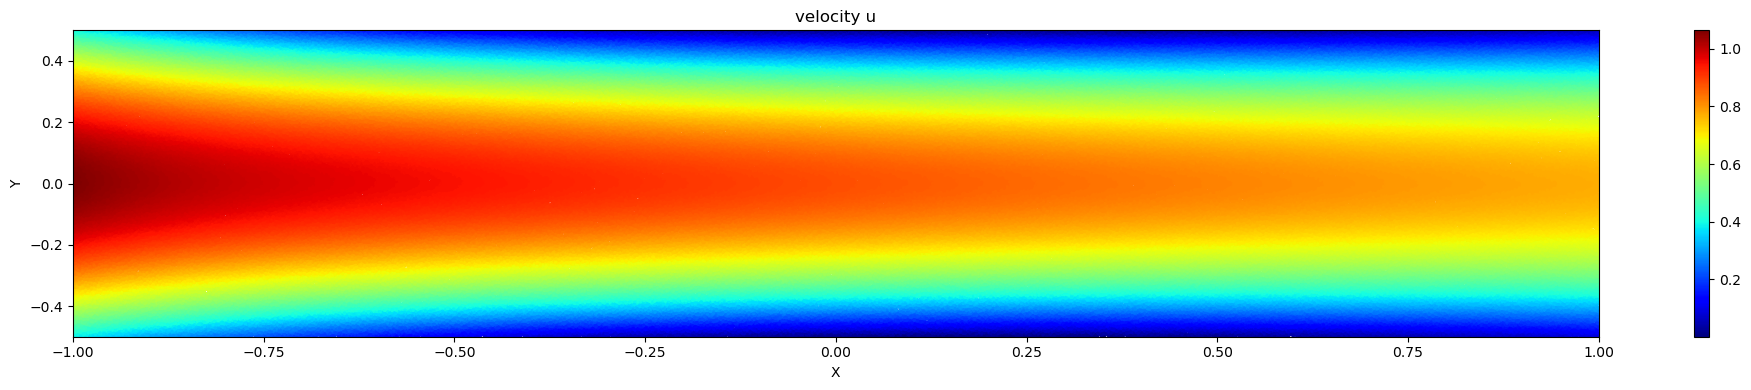

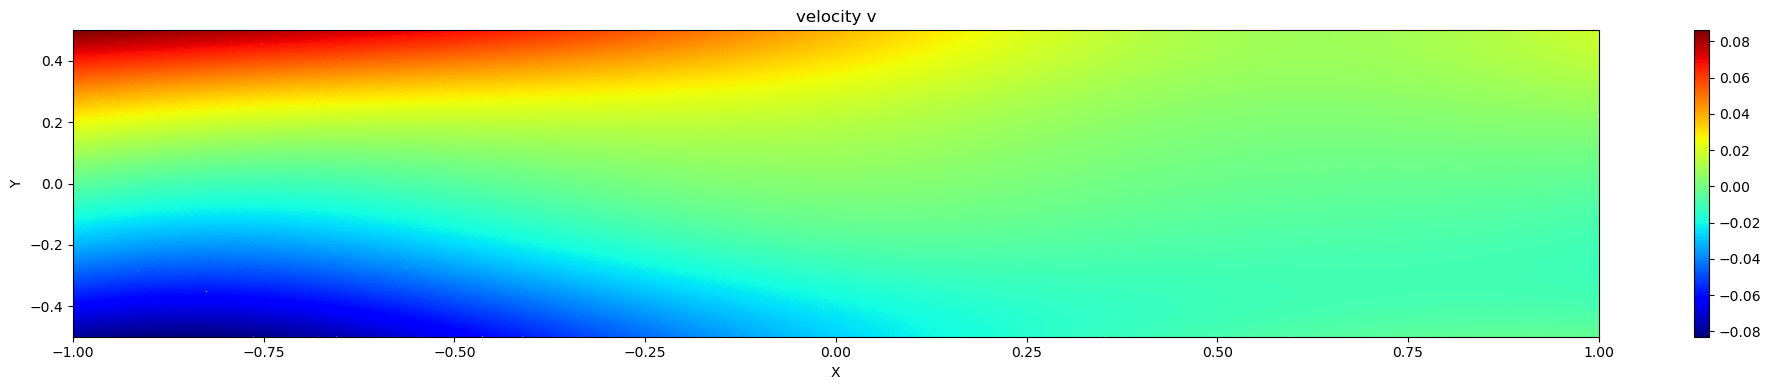

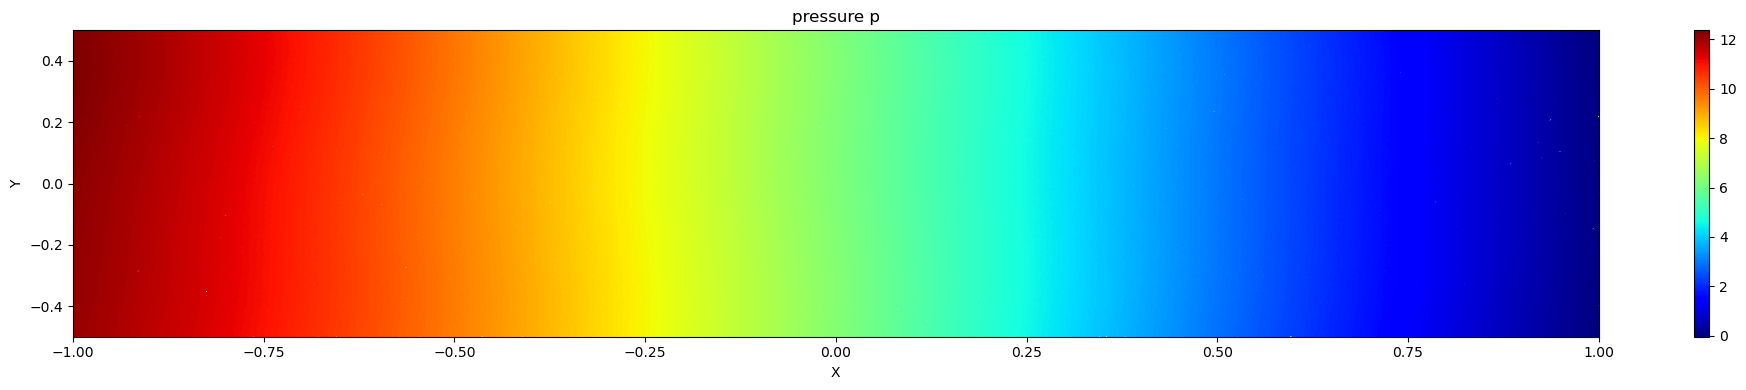

In [12]:
samples = np.random.rand(500000, 2)
samples[:, 0] = (samples[:, 0] - 0.5) * L    
samples[:, 1] = (samples[:, 1] - 0.5) * D  

result = NN.predict(samples)



titles = ['velocity u', 'velocity v', 'pressure p']

for idx, title in enumerate(titles):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],  # Assuming z coordinate is the third dimension
                c=result[:, idx],
                cmap='jet',
                s=2)
    plt.colorbar()
    plt.title(title) 
    plt.xlabel('X') 
    plt.ylabel('Y')  
    #plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))  
    plt.ylim((-D/2, D/2))  
    plt.tight_layout()
    plt.savefig(f'plot_{idx+1}_{title}.png')
    plt.show()
